# Порсонализация предложений для постоянных клиентов интернет магазина "В один клик"
_____
**Описание исследования.**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.    
_____
**Задачи исследования.**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
_____
**Исходные данные.**    

*market_file.csv*

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

*market_money.csv*

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

*market_time.csv*

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

*money.csv*

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.
______

**Данное исследование разделим на несколько частей.**

[**Часть 1. Загрузка и изучение данных:**](#section_1)

[**Часть 2. Предобработка данных:**](#section_2)

[**Часть 3.Исследовательский анализ данных:**](#section_3)

[**Часть 4. Выбор активных пользователей:**](#section_4)

[**Часть 5. Объединение таблиц:**](#section_5)

[**Часть 6. Корреляционный анализ:**](#section_6)

[**Часть 7. Паплайны:**](#section_7)

[**Часть 8. Анализ важности признаков:**](#section_8)

[**Часть 9. Сегментация покупателей:**](#section_9)

[**Часть 10. Общий вывод:**](#section_10)


# 1. Загрузка и изучение данныx
<a id='section_1'></a>

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn==1.1.3 -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
# импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, 
                                   OrdinalEncoder, MinMaxScaler, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
import phik
import shap

# создание константы RANDOM_STATE
RANDOM_STATE = 42
# размер тестовой выборки TEST_SIZE
TEST_SIZE = 0.25


In [5]:
# пути загружаемых датасетов
pth1 = '/datasets/market_file.csv'
pth2 = '/datasets/market_money.csv'
pth3 = '/datasets/market_time.csv'
pth4 = '/datasets/money.csv'

# проверка пути к загружаемым датасетам
if os.path.exists(pth1):
    #загрузка данных из файла 'market_file.csv'
    market_file = pd.read_csv(pth1)
    # отобразим загруженные датасеты
    display(market_file.head())
else:
    print(f"Не верный путь к файлу: {pth1}")
if os.path.exists(pth2):
    #загрузка данных из файла 'market_money.csv'
    market_money = pd.read_csv(pth2)
    # отобразим загруженные датасеты
    display(market_money.head())
else:
    print(f"Не верный путь к файлу: {pth2}")
if os.path.exists(pth3):
    #загрузка данных из файла 'market_time.csv'
    market_time = pd.read_csv(pth3)
    # отобразим загруженные датасеты
    display(market_time.head())
else:
    print(f"Не верный путь к файлу: {pth3}")
if os.path.exists(pth4):
    #загрузка данных из файла 'money.csv'
    money = pd.read_csv(pth4, sep = ';', decimal=',')
    # отобразим загруженные датасеты
    display(money.head())
else:
    print(f"Не верный путь к файлу: {pth4}!")


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод:** данные успешно загружены.

In [6]:
def studying_dataset_data(data, columns):
    """
    Функция для просмотра основной информации датасета и переименования
    столбцов.
    data - обрабатываемый датасет
    columns - названия столбцов датасета
    """
    columns = columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    print(data.info())
    return columns

In [7]:
# применение функции studying_dataset_data к датасету market_file
market_file.columns = studying_dataset_data(market_file, market_file.columns)
display(market_file.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
# применение функции studying_dataset_data к датасету market_money
market_money.columns = studying_dataset_data(market_money, market_money.columns)
display(market_money.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
# применение функции studying_dataset_data к датасету market_time
market_time.columns = studying_dataset_data(market_time, market_time.columns)
display(market_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
# применение функции studying_dataset_data к датасету money
money.columns = studying_dataset_data(money, money.columns)
display(money.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод:** в данных отсутствуют пропуски. Типы данных в норме. Столбцы были приведены к змеиному регистру, пробелы в названиях столбцов заменены на нижнее подчеркивание.

# 2. Предобработка данных
<a id='section_2'></a>

In [11]:
# проверка на явные дупликаты датасета market_file
def data_duplicate(data):
    """
    Функция поиска явных и неявных дубликатов.
    data - обрабатываемый датасет
    """
    duplicate = data.duplicated().sum()
    if duplicate == 0:
        print('Количество дубликатов в датасете: ', duplicate, '\n')
    else:
        print('Количество дубликатов в датасете: ', duplicate)
        data = data.drop_duplicates()
        if data.duplicated().sum() == 0:
            print('Удаление дубликатов прошло успешно.')
        else:
            print('Ошибка!')
    for i in data.columns:
        if data[i].dtypes == 'object':
            data[i] = data[i].str.lower()
            print(f"Столбец '{i}': \n", data[i].unique())
    return data

In [12]:
# применение функции data_duplicate к датасету market_file
market_file = data_duplicate(market_file)

Количество дубликатов в датасете:  0 

Столбец 'покупательская_активность': 
 ['снизилась' 'прежний уровень']
Столбец 'тип_сервиса': 
 ['премиум' 'стандартт' 'стандарт']
Столбец 'разрешить_сообщать': 
 ['да' 'нет']
Столбец 'популярная_категория': 
 ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [13]:
# применение функции data_duplicate к датасету market_money
market_money = data_duplicate(market_money)

Количество дубликатов в датасете:  0 

Столбец 'период': 
 ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [14]:
# применение функции data_duplicate к датасету market_time
market_time = data_duplicate(market_time)

Количество дубликатов в датасете:  0 

Столбец 'период': 
 ['текущий_месяц' 'предыдцщий_месяц']


In [15]:
# применение функции data_duplicate к датасету money
money = data_duplicate(money)

Количество дубликатов в датасете:  0 



Таким образом, все значения типа данных 'object' приведены к змеиному регистру, явные дубликаты не обнаружены, но есть несколько неявных дубликатов. В датасете *market_file* в столбце 'тип_сервиса' необходимо заменить 'стандартт' на 'стандарт', в датасете *market_time* в столбце 'период' необходимо заменить 'предыдцщий_месяц' на 'предыдущий_месяц'. 

In [16]:
# устранение нейявных дубликатов и некорректных данных
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса']\
= 'стандарт'
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период']\
= 'предыдущий_месяц'

In [17]:
# применение функции data_duplicate к датасету market_file
market_file = data_duplicate(market_file)

Количество дубликатов в датасете:  0 

Столбец 'покупательская_активность': 
 ['снизилась' 'прежний уровень']
Столбец 'тип_сервиса': 
 ['премиум' 'стандарт']
Столбец 'разрешить_сообщать': 
 ['да' 'нет']
Столбец 'популярная_категория': 
 ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [18]:
# применение функции data_duplicate к датасету market_time
market_time = data_duplicate(market_time)

Количество дубликатов в датасете:  0 

Столбец 'период': 
 ['текущий_месяц' 'предыдущий_месяц']


**Вывод:** неявные дубликаты и некорректные данные устранены, явные дубликаты не обнаружены.

# 3. Исследовательский анализ данных
<a id='section_3'></a>

**market_file** 

Иследовательский анализ данных. Проверим данные на аномалии и выбросы.

In [19]:
def categoral(data, col):
    """
    Функция построения графика для категориальных признаков.
    data - обрабатываемый датасет
    col - признаки, для которых строятся графики
    """
    plt.figure(figsize=(10,4))
    ax = sns.countplot(y=col, data=data, palette='pastel')
    total = data[col].count()
    for p in ax.patches:
        count = p.get_width()
        percentage = 100 * count / total
        ax.annotate(f'({percentage:.1f}%)', 
                    (count, p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', 
                    fontsize=11, color='black', 
                    xytext=(5, 0), 
                    textcoords='offset points')
    ax.set_title(f'График рапределение по {col}', fontsize=16)
    ax.set_ylabel('Количество', fontsize=14)
    plt.show()
    
    
def hist_with_boxplot(dаta, col, target):
    """
    Функция построения графиков
    data - обрабатываемый датасет
    col - признаки, для которых строятся графики
    target - целевая переменная
    """
    f, ax = plt.subplots(1, 2, figsize=(22, 4))
    ax[0].set_title(f'Гистограмма для {col}', fontsize=16)
    ax[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(dаta, bins=20, kde=True, ax=ax[0], hue=target, x=col, palette='pastel')
    else:
        sns.histplot(dаta, bins=20, kde=True, ax=ax[0], x=col, palette='pastel')
    ax[1].set_title(f'График ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=dаta, ax=ax[1], y=col, palette='pastel')
    ax[1].set_ylabel(col, fontsize=14)
    plt.show()


In [20]:
# списки наименования столбцов для построения графиков
categor = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
target = 'покупательская_активность'
num = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит',\
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']

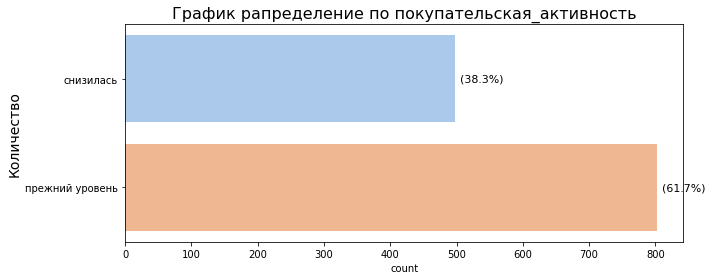

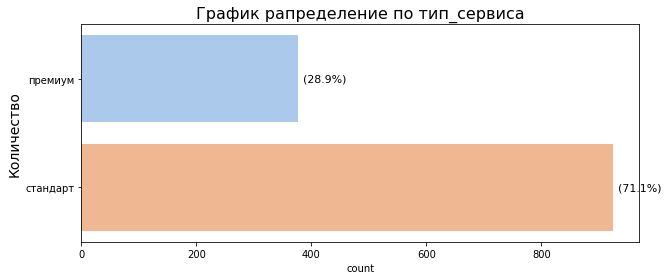

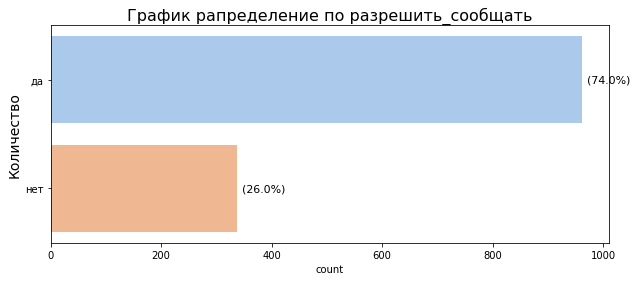

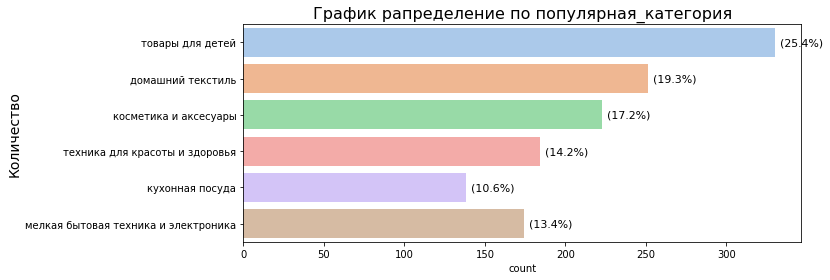

In [21]:
# цикл для построения графиков по столбцам из раздела categor
for i in categor:
    categoral(market_file, i)

- в целевом признаке наблюдается явный дисбаланс
- пользователей в сегменьте премиум меньше в 2 раза, чем в стандартном
- самая популярная категория товары для детей, а кухонная посуда самая не популярная

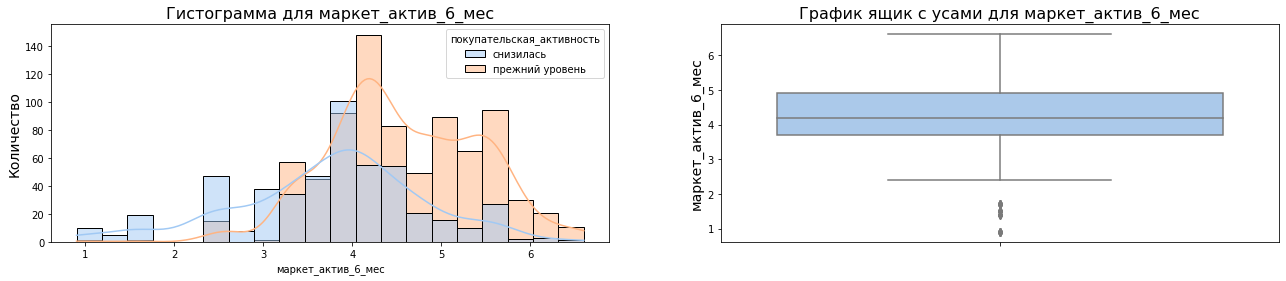

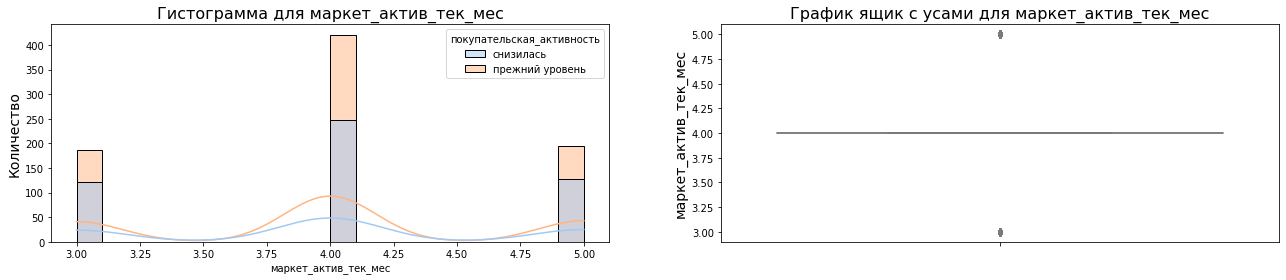

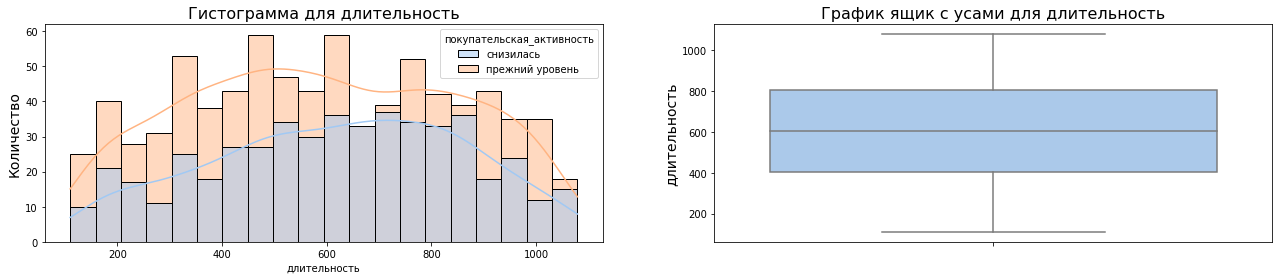

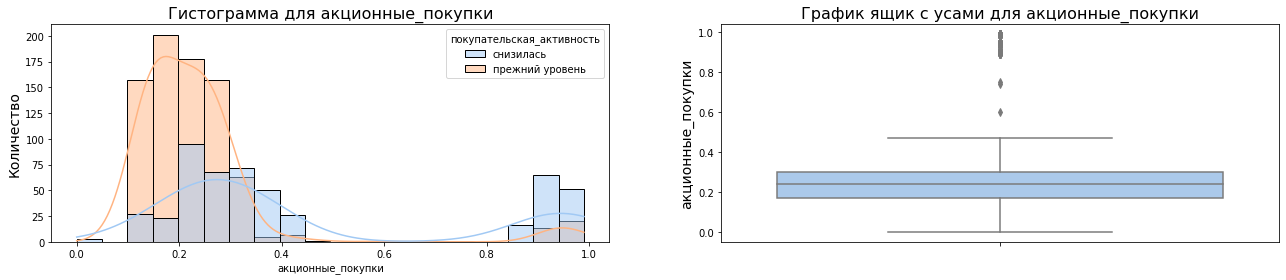

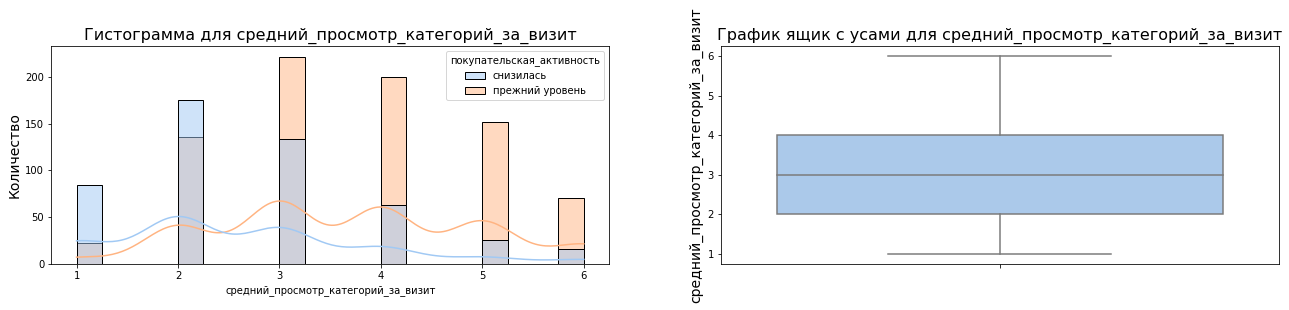

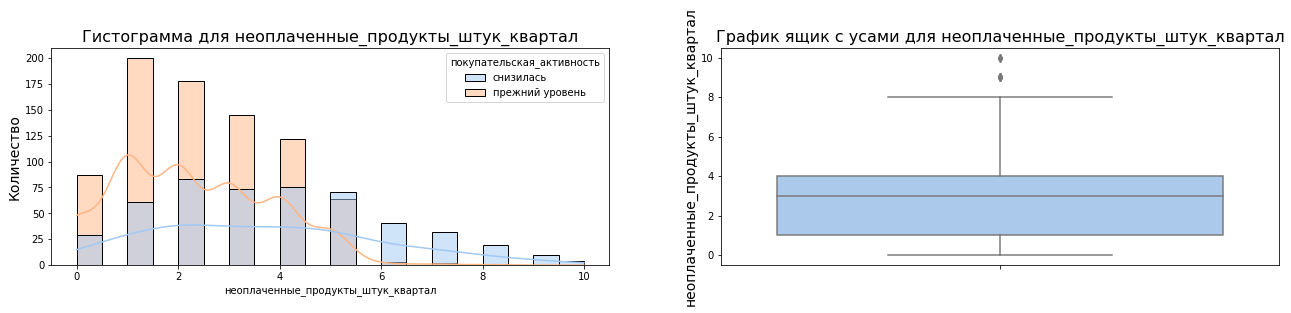

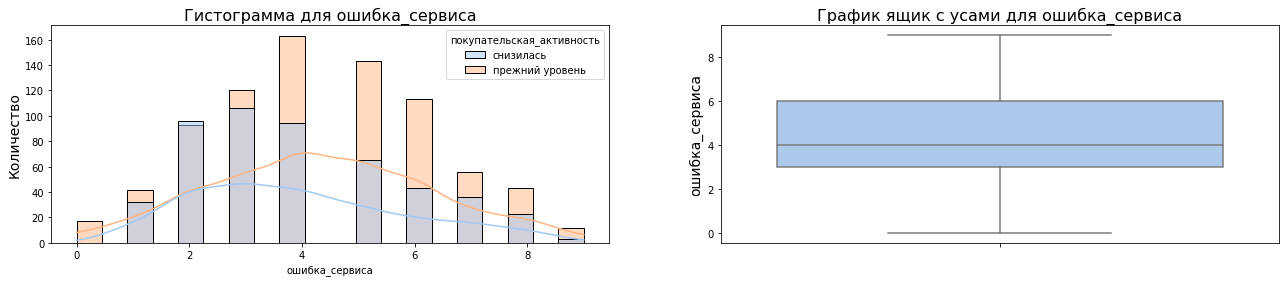

In [22]:
# цикл для построения графиков по столбцам из раздела num
for i in num:
    hist_with_boxplot(market_file, i, target)

Явных выбросов и аномалий не обнаружено.

**market_money** 

Иследовательский анализ данных. Проверим данные на аномалии и выбросы.

In [23]:
# списки наименования столбцов для построения графиков
categor = 'период'
target = 'покупательская_активность'
num = 'выручка'

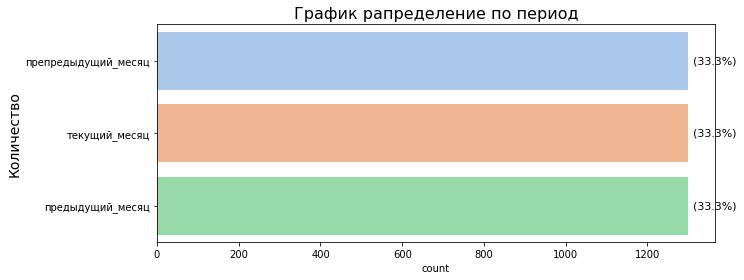

In [24]:
# построение графиков по столбцам из раздела categor
categoral(market_money, categor)

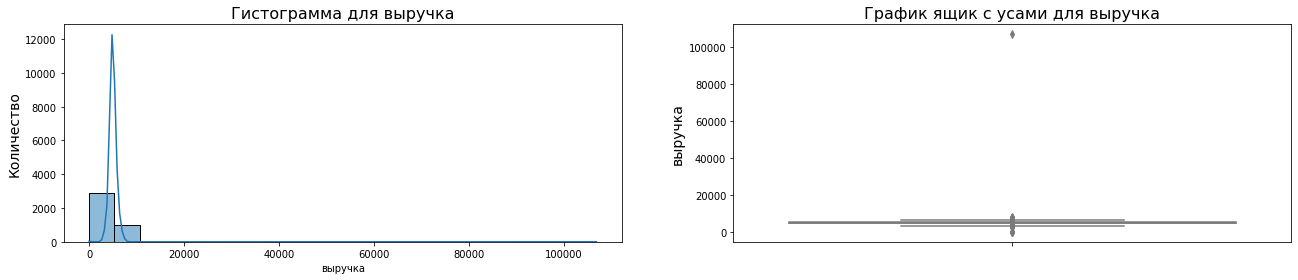

In [25]:
# построение графика по столбцам из раздела num
hist_with_boxplot(market_money, num, None)

У признака 'выручка' обнаружен обнаружен выброс, необходимо его удалить.

In [26]:
market_money = market_money[market_money['выручка'] != market_money['выручка'].max()]

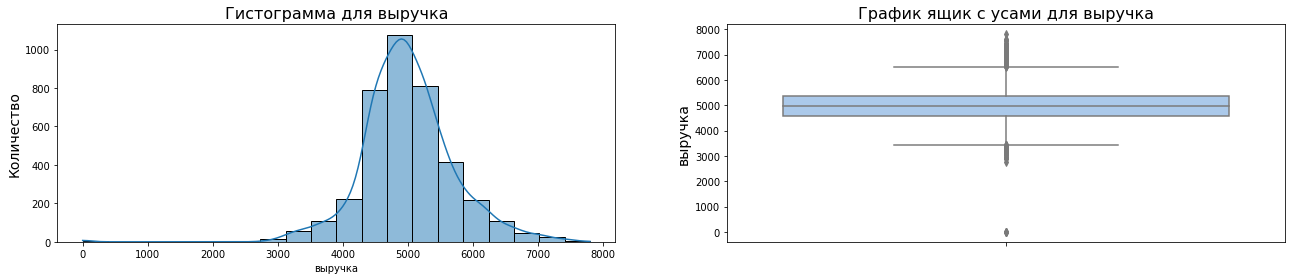

In [27]:
# построение графика по столбцам из раздела num
hist_with_boxplot(market_money, num, None)

Около 0 также обнаружены выбросы.

In [28]:
market_money = market_money[market_money['выручка'] != 0]

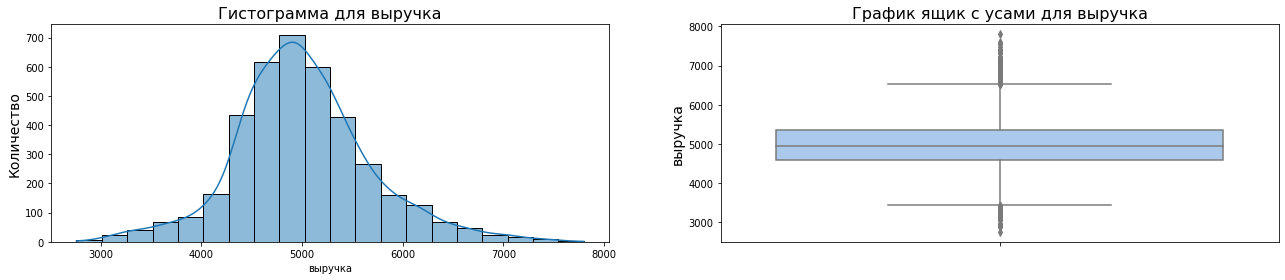

In [29]:
# построение графика по столбцам из раздела num
hist_with_boxplot(market_money, num, None)

Выбросы успешно удалены.

**market_time** 

Иследовательский анализ данных. Проверим данные на аномалии и выбросы.

In [30]:
# списки наименования столбцов для построения графиков
categor = 'период'
target = 'покупательская_активность'
num = 'минут'

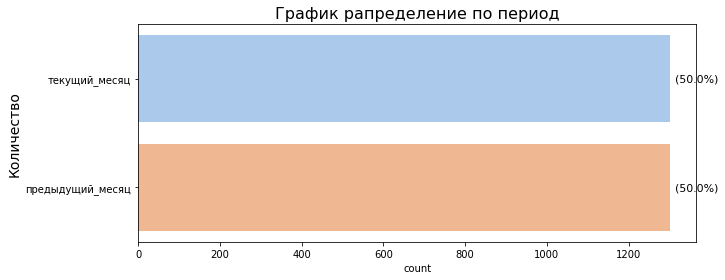

In [31]:
# построение графиков по столбцам из раздела categor
categoral(market_time, categor)

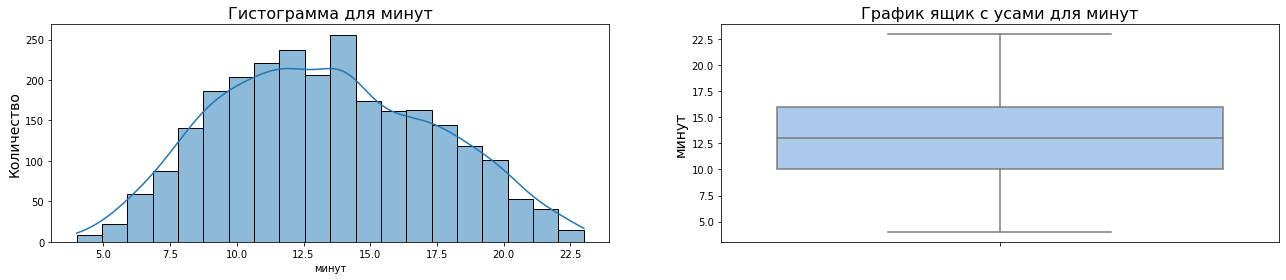

In [32]:
# построение графика по столбцам из раздела num
hist_with_boxplot(market_time, num, None)

Аномалий и выбросов не обнаружено.

**money** 

Иследовательский анализ данных. Проверим данные на аномалии и выбросы.

In [33]:
# списки наименования столбцов для построения графиков
target = 'покупательская_активность'
num = 'прибыль'

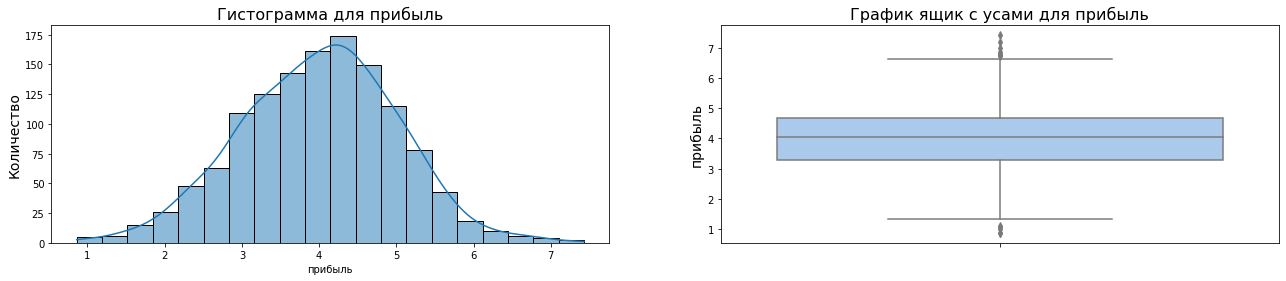

In [34]:
# построение графика по столбцам из раздела num
hist_with_boxplot(money, num, None)

Аномалий и выбросов не обнаружено.

**Вывод** в ходе исследования было устранено небольшое количество аномалий. Критичных проблем в данных не обнаружено.

# 4. Выбор активных пользователей
<a id='section_4'></a>

Необходимо отобрать пользователей с активностью не менее 3 месяцев.

In [35]:
# отбор пользователей с активность не менее 3 месяцев в датасете market_money
pivot_table = market_money.pivot_table(index = 'id', values = 'период', aggfunc = 'count')
ids_with_period_3 = pivot_table[pivot_table['период'] == 3].index

In [36]:
# отбор пользователей с активность не менее 3 месяцев в датасете market_file
market_file = market_file[market_file['id'].isin(ids_with_period_3)]

In [37]:
len(market_file)

1296

**Вывод** Таким образов, отфильтровалось 4 пользователя.

# 5. Объединение таблиц
<a id='section_5'></a>

Объединим 'market_file', 'market_money', 'market_time' в одну таблицу.

In [38]:
market_money_g = market_money.pivot_table(index=['id'], columns=["период"])
market_money_g.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_g['id'] = market_money_g.index

In [39]:
market_time_g = market_time.pivot_table(index=['id'], columns=["период"])
market_time_g.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_g['id'] = market_time_g.index

In [40]:
market_join = market_file.join(market_money_g, on='id', lsuffix="_left", rsuffix="_выручка")
market_join = market_join.rename(columns={'id_left':'id'})
market_join = market_join.join(market_time_g, on='id', lsuffix="_left", rsuffix="_минут")
market_join = market_join.rename(columns={'id_left':'id'})
market_join = market_join.drop(['id_выручка', 'id_минут'], axis=1)
display(market_join.head())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Вывод** таблицы успешно объединены.

# 6. Корреляционный анализ
<a id='section_6'></a>

Матрица корреляции для всех признаков (количественных и категориальных).

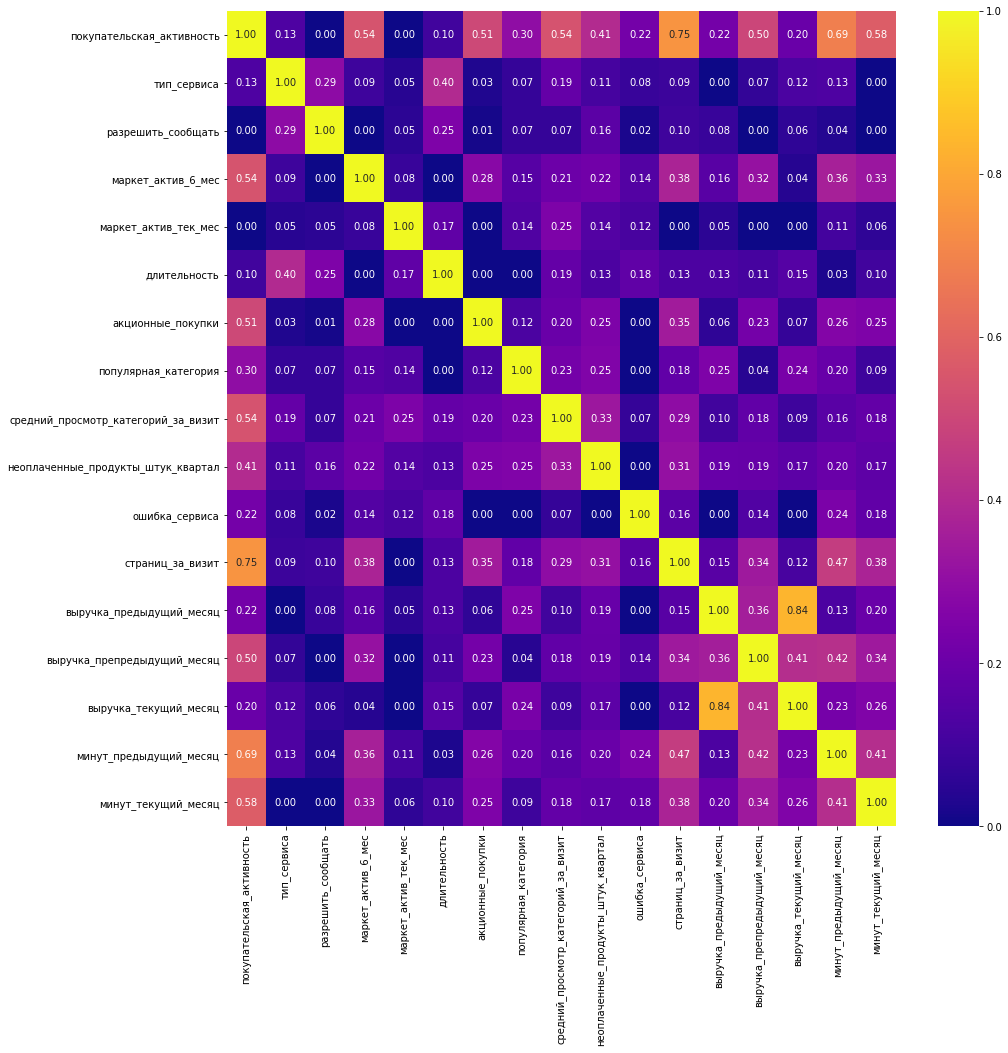

In [41]:
fig, ax = plt.subplots(figsize=(15, 15))
market_join_without_id = market_join.drop(columns=['id'])
sns.heatmap(market_join_without_id.phik_matrix(interval_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки',\
                                                                'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',\
                                                                'выручка_текущий_месяц', 'минут_предыдущий_месяц',\
                                                                'минут_текущий_месяц']), annot=True, fmt='.2f', cmap='plasma'
)
plt.show()

**Вывод**
- целевой признак имеет корреляцию со следующими признаками 'минут_текущий_месяц', 'минут_предыдущий_месяц', 'выручка_препредыдущий месяц', 'страниц_за_визит', 'средний_просмотр_категорий_за_визит', 'акционные_покупки', 'маркет_актив_6_мес'
- в датасете отсутствуют признаким с корреляцией больше 0.9, значит отсутствует мультикорре

# 7. Паплайны
<a id='section_7'></a>

Необходимо переберать модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() используя пайплайны. Для этого целевой признак унеобходимо преобразовать.

In [42]:
X = market_join.drop(['покупательская_активность','id'], axis=1)
y = market_join['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)
# создание экземпляра класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучение модель и трансформирование тренировочной выборки
y_train = label_encoder.fit_transform(y_train)

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

In [43]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['акционные_покупки', 'маркет_актив_тек_мес', 'маркет_актив_6_мес','длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [44]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first'))
    ]
)

In [45]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандрат', 'премиум']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [46]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [47]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [48]:
param_grid = [
    # модель DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # модель KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # модель LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # модель SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__C': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [49]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Будем использовать метрику 'roc_auc', так как она хорошо работает при дисбалансе выборки. Данная метрика оценивает способность модели разделять на классы. Чем выше значение, тем лучше работает модель.

In [50]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps...
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__C': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [51]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика на кросс_валидации:', round(randomized_search.best_score_, 5))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                        

In [52]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 5)}')

Метрика ROC-AUC на тестовой выборке: 0.91672


Также будем использовать метрику f1_score для проверки качества модели. Так как на неё нет влияния дисбаланса, который присутствует в наших данных.

In [53]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 5)}')

Метрика F1-score на тестовой выборке: 0.89298


**Вывод** была отобрана лучшая модель LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'). Метрика 'roc_auc' для тренеровочной выборки показала результат 0.9, а на тестовой 0.92. Метрика 'f1-score' показала результат высокий результат 0.9, что говорит о качестве отобраной модели.

# 8. Анализ важности признаков
<a id='section_8'></a>

In [ ]:
best_model = randomized_search.best_estimator_
svc_model = best_model.named_steps['models']

X_train_2 = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(svc_model.predict_proba, X_train_2)
shap_values = explainer(X_test_2)

features_out = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist() + num_columns\
+ ord_columns

shap.summary_plot(shap_values[:, :, 1], X_test_2, plot_type="bar", feature_names=features_out, plot_size=(14,8), color='blue')

plt.show()

PermutationExplainer explainer:  60%|█████▉    | 193/324 [00:49<00:38,  3.40it/s]

**Вывод** таким образом, выделим 3 признака оказывающих больше всего влияния на разработанную модель. На первом месте признак 'страниц_за_визит', на втором 'средний_просмотр_категорий_за_визит', на 3 месте 'минут_предыдщий_месяц'.

# 9. Сегментация покупателей
<a id='section_9'></a>

Сегминтацию будем проводить для группы клиентов, которые покупают товары из для детей.

In [ ]:
child_product = pd.merge(market_join, money, on='id', how ='inner')
child_product = child_product[child_product['популярная_категория'] == 'товары для детей']

In [ ]:
reduce = len(child_product[child_product['покупательская_активность']=='снизилась'])
norm = len(child_product[child_product['покупательская_активность']=='прежний уровень'])
data = [reduce, norm]
labels = ['снизилась', 'прежний уровень']
plt.figure(figsize=(8,8))
plt.rc('font', size= 20 ) 
print(reduce)
print(norm)

plt.pie(data, labels = labels, autopct='%.0f%%')
plt.title('Соотношение покупательской активности клиентов\n из категории «Товары для детей»', 
          fontsize=20)
plt.show() 

Таким образом, покупательская активность снизилась у 145 пользователей, не изменилась у 184 пользователей.

In [ ]:
reduce = len(child_product[child_product['тип_сервиса']=='премиум'])
norm = len(child_product[child_product['тип_сервиса']=='стандарт'])
data = [reduce, norm]
labels = ['премиум', 'стандарт']
plt.figure(figsize=(8,8))
plt.rc('font', size= 20 ) 
print(reduce)
print(norm)

plt.pie(data, labels = labels, autopct='%.0f%%')
plt.title('Соотношение покупательской активности клиентов\n из категории «Товары для детей»', 
          fontsize=20)
plt.show() 

Таким образом, 91 пользователей используют тип сервиса премиум, а 238 тип сервиса стандарт.

In [ ]:
month_1 = child_product['выручка_препредыдущий_месяц'].sum()
month_2 = child_product['выручка_предыдущий_месяц'].sum()
month_3 = child_product['выручка_текущий_месяц'].sum()
print(f'Выручка за препредыдущий месяц {month_1}')
print(f'Выручка за предыдущий месяц {month_2}')
print(f'Выручка за текущий месяц {month_3}')

Заметен рост выручки за последний 3 месяца.

In [ ]:
ax = child_product[child_product['покупательская_активность'] == 'снизилась']['прибыль'].plot(kind='hist', bins= 50, grid=False, figsize=(16,10), alpha=0.5)
ax = child_product[child_product['покупательская_активность'] == 'прежний уровень']['прибыль'].plot(kind='hist', bins= 50, grid=False, figsize=(16,10), alpha=0.5)
ax.set_xlabel('Гистограмма прибыли с клиентов из разных сигментов')
ax.set_ylabel('Количество клиентов')
plt.show()

**Вывод** наибольшее количество клиентов из категории «Товары для детей» приносит прибыль от 3000 до 5000 рублей в месяц. За последний 3 месяца заметно увеличение выручки. Также на покупательскую способность влияют акционные продажи.

Таким образом, стоит активнее продавать товары от 3000 до 5000 рублей для пользователей тип сервиса стандарт. Это именно сегмент пользователей, которые покупают товары для дете.

# 10. Общий вывод
<a id='section_10'></a>

Была проделана следующая работа:
- загружены и обработаны данные
- проведен анализ на поиск дубликатов и пропусков
- проведен корреляционный анализ
- в процессе поиска к данным применено 4 типа моделей классифкации и на основе метрики roc-auc проведен отбор лучшей модели
- на основе метрики roc-auc была отобрана лучшая модель LogisticRegression c использованием пайплайна
- построен график важности признаков полученной модели
- в сегменте товаров для детей заметно влияние акционных продаж, также это обычно пользователи и сегмента стандарт, делающие покупки от 3000 до 5000 рублей